# Predicting Wine Quality Score

**Authors**: Xander Dawson, Zackarya Hamza, Sid Ahuja

In [17]:
library(tidyverse, quietly = TRUE)
library(tidymodels, quietly = TRUE)
library(repr, quietly = TRUE)
library(psych, quietly = TRUE)
library(kknn, quietly = TRUE)

## Summary

In this report we attempt to build a k-nearest neighbors (k-nn) classification model which predicts the quality of a Portuguese white wine based on its chemical components and physical properties. The dataset classified the wine qualities on a 10-point scale which we transformed to a binary classification problem where wines with scores of 0-5 are considered low-quality and scores of 6-10 are considered high-quality. Our final model had an accuracy of 0.77, correctly predicting 77% of the test set samples. It did a better job at correctly predicting good quality wines than bad quality wines with a recall score of 0.89. While this model can definitely be improved upon, the implications of incorrect predictions are not very harmful. Additionally, it is likely that this model will not be used solely to make decisions about wine quality and production, but rather be used alongside with other tools and rankings by professional sommeliers as well as personal preferences of consumers. With this, we believe this model can be used to make predictions about Portuguese white wines but will require further training to be used on other wines.

## Introduction

Portugal is internationally recognized for its exceptional wines and booming wine industry. This distinction is rooted in the country’s rich viniculture history and its diverse climatic conditions, which contribute to the production of wines with unique flavors and aromas. However, with the wine market becoming increasingly saturated and competitive, the ability to accurately assess the quality of wine based on objective measurements has become highly valuable. The quality of a wine is heavily influenced by its various chemical components and physical properties and such features can be used to predict the quality of a wine (Fernandes Ferreira Madureira et al., 2013).

In this report, we aim to explore the application of machine learning algorithms in predicting the quality of Portuguese white wines, based on their chemical compositions and physical properties. Our goal is to develop a predictive model that can distinguish between high and low-quality wines with a high degree of accuracy. The significance of such a model lies in its potential to provide consumers with quality predictions prior to purchase as well as provide produced with information on ways to improve their wines; our model should be particularly good at identifying good wines to provide such information to manufacturers. Through the application of machine learning, this study contributes to the growing field of data-driven approaches in food science and quality assurance, marking a step towards the integration of technology and quality wine production.

## Methods

### Data

In order to explore and build a wine quality classification model, we are using the wine quality data set sourced from the UCI Machine Learning Repository and created by P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis from the University of Minho in Portugal (Cortez et al., 2009). Specifically, we are interested in predicting white wine quality based on the chemical composition of the wine. Each row represents a white wine and the chemical measurements taken from the wine and there are 4898 samples in the dataset. The target value (integer wine quality score) was determined by the Vinho Verde Wine Commission (CVRVV) of Portugal.

| Feature | Type | Description|
|:---:|:---:|:---:|
| Fixed Acitity | Coninuous | Concentration (g/L) of tartaric acid.<br />Impacts the tartness of wines. |
| Volatile Acitity | Coninuous | Concentration (g/L) of acetic acid.<br />Impacts the vinegar-like taste in wines. |
| Citric Acid | Coninuous | Concentration (g/L) of citric acid.<br />Impacts the freshness of wines. |
| Residual Sugar | Coninuous | Concentration (g/L) of sugar remaining after fermentation.<br />Impacts the sweetness of wines. |
| Chlorides | Coninuous | Concentration (g/L) of chlorides.<br />Impacts the saltiness of wines. |
| Free Sulfur Dioxide | Coninuous | Concentration (mg/L) of unbound SO2.<br />Prevents microbial growth. |
| Total Sulfur Dioxide | Coninuous | Concentration (mg/L) of total SO2.<br />Prevents microbial growth and impacts aroma/taste. |
| Density | Coninuous | Density (g/mL) measurement.<br />Relates alcohol to sugar content. |
| pH | Coninuous | Measurement of wine acidity. | 
| Suphates | Coninuous | Concentration (mg/L) of total sulphates. |
| Alcohol | Coninuous | Percentage (%) of alcohol content. |

*Table 1: Column descriptions of the dataset*

### Analysis

To predict the wine quality, we utilized the k-nearest neighbors (k-nn) algorithm and built a classification model based on certain features within the dataset (specifically alcohol, volatile acidity, total sulfur dioxide content, density, chlorides, and residual sugar of the wines). First we converted the `quality_score` target column into a quality_class column where scores 0-5 were considered bad and scores 6-10 were considered good. We did this to reduce the number of target classes (creating a binary classification problem) as well as to allow for more examples within each class. Then we split the data into train (70%) and test splits (30%). All selected features were scaled prior to model training. We selected the features based on a qualitative analysis of their distribution for each class; features that greatly overlapped across classes were dropped. Then, the best value for hyperparameter `K` was determined using a 10-fold cross-validation test. For this model, we determined `accuracy` to be the best measurement/metric for assessing our model as there are a similar number of samples within each class. For the confusion matrix metrics, we consider good to be the positive category and bad to be the negative category. The R programming language (R Core Team, 2023) and the following packages were used to perform the analysis: tidyverse (Wickham et al., 2019), tidymodels (Kuhn et al., 2020), repr (Angerer et al., 2023), psych (Revelle, 2024), and kknn (Hechenbichler K, 2016).

## Results

In [2]:
# data downloaded as zip from UCI Machine Learning Repository and unzipped file is moved to /data
url <- "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
temp <- tempfile()
download.file(url, temp)
unzip(temp, exdir = "./data/raw")

In [3]:
# preprocessing data
# read csv file and replace column header
white_wine <- read_delim("data/raw/winequality-white.csv", delim = ";", show_col_types = FALSE)
colnames(white_wine) <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                          "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
                          "pH", "sulphates", "alcohol", "quality_score")

# changing quality_score to quality_category
white_wine <- white_wine %>% 
    mutate(quality_category = case_when(
        quality_score <= 5 ~ "bad",
        quality_score <= 10 ~ "good")) %>%
    mutate(quality_category = as_factor(quality_category)) %>%
    select(-quality_score)

head(white_wine)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_category
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,good
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,good
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,good
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,good
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,good
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,good


*Table 2: Raw data with quality divided into 2 classes*

In [4]:
# creating the train, test and cross-validation splits
set.seed(321)
wine_split <- initial_split(white_wine, prop = 0.70, strata = quality_category)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

write_csv(wine_train, "data/processed/white_wine_train.csv")
write_csv(wine_test, "data/processed/white_wine_test.csv")

In [5]:
# feature scaling recipe to generate scaled csv files
wine_preprocess_recipe <- recipe(quality_category ~ ., data = wine_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

prep_preprocess_recipe <- prep(wine_preprocess_recipe, training = wine_train)

scaled_wine_train <- bake(prep_preprocess_recipe, new_data = wine_train)
scaled_wine_test <- bake(prep_preprocess_recipe, new_data = wine_test)

write_csv(scaled_wine_train, "data/processed/scaled_white_wine_train.csv")
write_csv(scaled_wine_test, "data/processed/scaled_white_wine_test.csv")

In [6]:
# summary statistics of the training data (no scaling)
describe(wine_train) %>%
    select(n, mean, sd, median, min, max, range)

,n,mean,sd,median,min,max,range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fixed_acidity,3428,6.86471704,0.835011349,6.8000,3.90000,14.20000,10.30000
volatile_acidity,3428,0.27729434,0.099621665,0.2600,0.08000,0.96500,0.88500
citric_acid,3428,0.33271004,0.117602650,0.3100,0.00000,1.00000,1.00000
residual_sugar,3428,6.41130397,5.087360092,5.3000,0.60000,65.80000,65.20000
chlorides,3428,0.04576109,0.021934202,0.0430,0.00900,0.34600,0.33700
free_sulfur_dioxide,3428,35.33270128,17.084649991,34.0000,2.00000,289.00000,287.00000
total_sulfur_dioxide,3428,138.04390315,42.261806615,134.0000,9.00000,440.00000,431.00000
density,3428,0.99407241,0.002995928,0.9938,0.98713,1.03898,0.05185
pH,3428,3.18758751,0.150233889,3.1800,2.74000,3.81000,1.07000


*Table 3: Summary statistics of each column in the dataset*

We can see that there are no missing values as well as the summary metrics for each column. This table is generated using unscaled data so that we can use out intuition and recall the specific units of each column, gaining a better understanding of the column characteristics.

In [7]:
# summary statistics of each feature for both classes
num_obs <- nrow(wine_train)
summary <- wine_train %>%
        group_by(quality_category) %>%
        summarize(
            count = n(),
            percentage = n() / num_obs * 100,
            fixed_acidity_avg = mean(fixed_acidity),
            volatile_acidity_avg = mean(volatile_acidity),
            citric_acid_avg = mean(citric_acid),
            residual_sugar_avg = mean(residual_sugar),
            chlorides_avg = mean(chlorides),
            free_sulfur_dioxide_avg = mean(free_sulfur_dioxide),
            total_sulfur_dioxide_avg = mean(total_sulfur_dioxide),
            density_avg = mean(density),
            pH_avg = mean(pH),
            sulphates_avg = mean(sulphates),
            alcohol_avg = mean(alcohol)
        )
summary

quality_category,count,percentage,fixed_acidity_avg,volatile_acidity_avg,citric_acid_avg,residual_sugar_avg,chlorides_avg,free_sulfur_dioxide_avg,total_sulfur_dioxide_avg,density_avg,pH_avg,sulphates_avg,alcohol_avg
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
good,2280,66.51109,6.804452,0.2618004,0.3322237,6.166338,0.04333070,35.52478,133.6243,0.9935585,3.198526,0.4925482,10.804820
bad,1148,33.48891,6.984408,0.3080662,0.3336760,6.897822,0.05058798,34.95122,146.8214,0.9950931,3.165862,0.4818554,9.859117


*Table 4: Summary statistics of each column by wine class*

About two-thirds of the dataset are wines under the good category, and the remaining one-third are bad wines (based on our definition of good/bad). Immediately we can see some features have similar averages between both categories and thus, those features may not be good to add in the model as they do a poor job discerning the class. However we still must consider the distributions of these features.

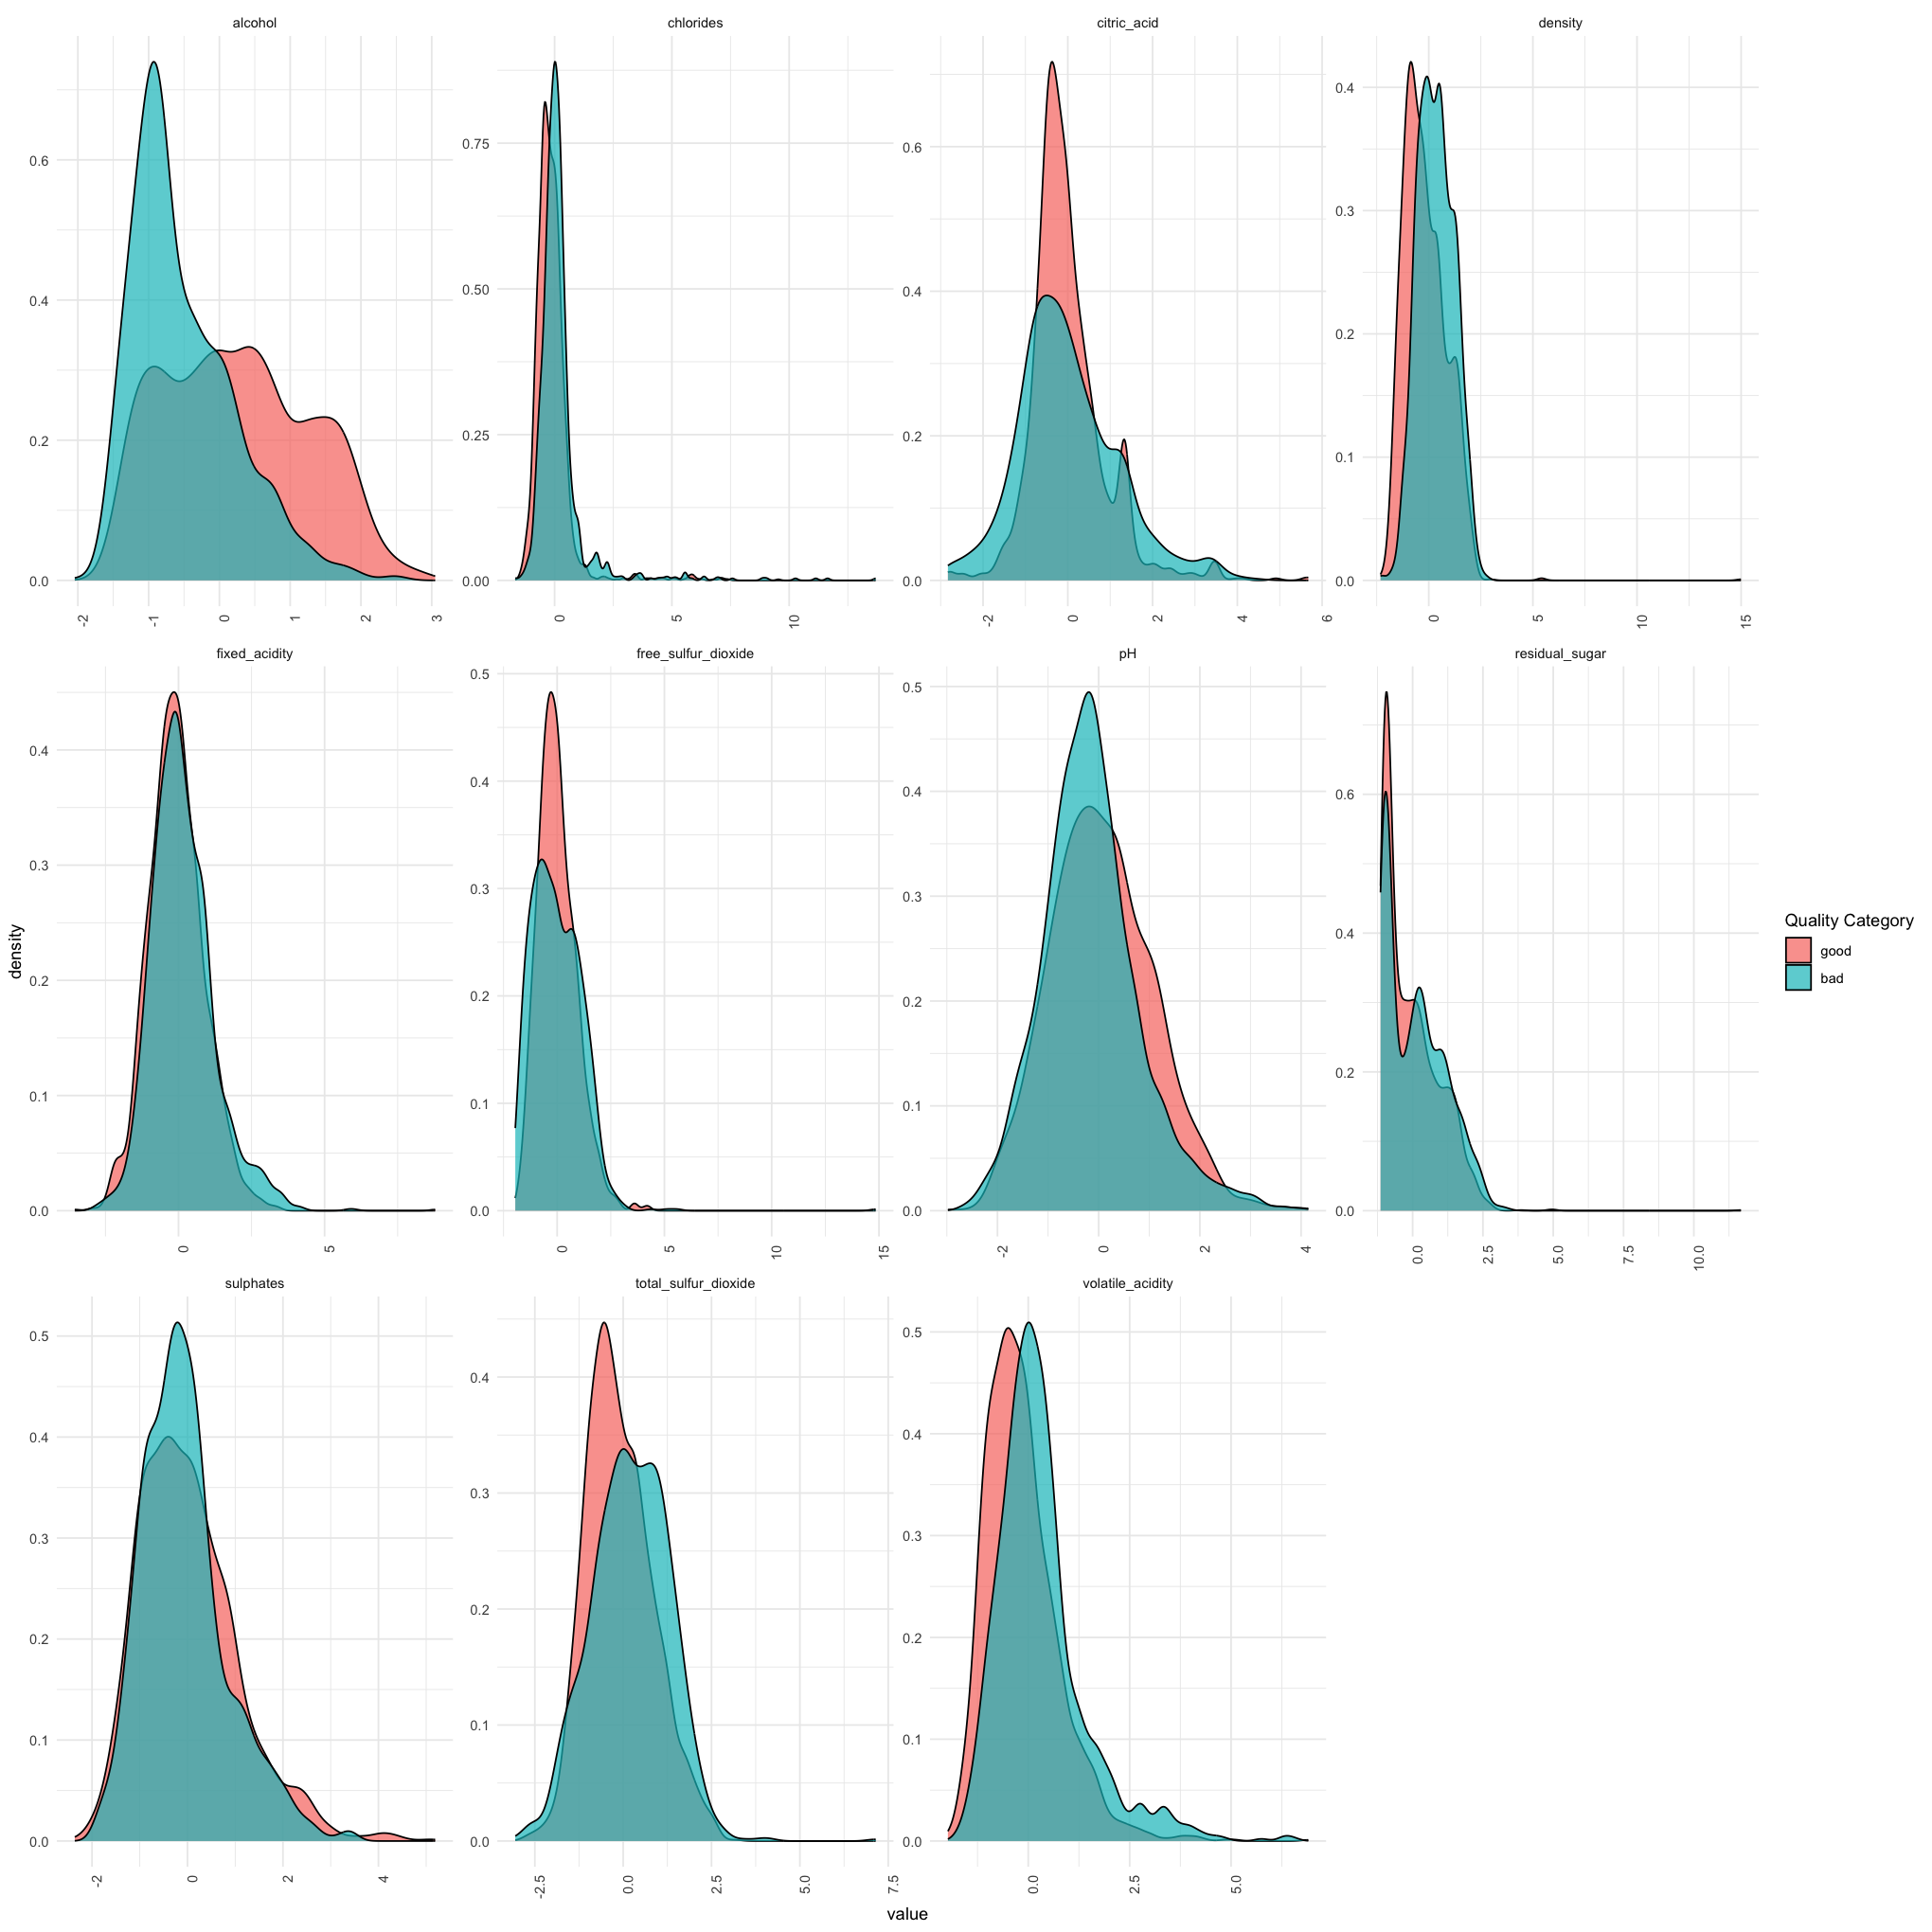

In [8]:
# feature selection - looking for features with distinct distributions
options(repr.plot.width=17, repr.plot.height=17)
scaled_wine_train_long <- scaled_wine_train %>%
                gather(key = "predictor", value = "value", -quality_category)

ggplot(scaled_wine_train_long, aes(x = value, fill = quality_category)) +
    geom_density(alpha = 0.7) +
    facet_wrap(~predictor, scales = "free") +
    theme_minimal() +
    labs(fill = "Quality Category") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

*Figure 1: Distributions of feature values between both classes of wine*

In the plots above, alcohol, volatile acidity, total sulfur dioxide content, density, chlorides, and residual sugar of the wines all seem to have distinct distributions for both classes of wine; the distributions have non-overlapping peaks and regions. Such features are good to add in the model because they can be used to identify one type of wine from the other.

In [9]:
# hyperparameter optimization - choosing k
set.seed(654)
wine_recipe <- recipe(quality_category ~ alcohol + volatile_acidity + 
                      total_sulfur_dioxide + density + chlorides + residual_sugar,
                      data = wine_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

wine_vfold <- vfold_cv(wine_train, v = 10, strata = quality_category)

In [10]:
# building the model for k selection
knn_spec <- nearest_neighbor(weight_func = "optimal",
                             neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

In [11]:
# fitting and generating results
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() %>%
            add_recipe(wine_recipe) %>%
            add_model(knn_spec) %>%
            tune_grid(resamples = wine_vfold, grid = k_vals) %>%
            collect_metrics()

accuracies <- knn_results %>%
            filter(.metric == "accuracy")

head(accuracies)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7710117,10,0.006437294,Preprocessor1_Model01
6,accuracy,binary,0.7678098,10,0.006442345,Preprocessor1_Model02
11,accuracy,binary,0.7683921,10,0.005156178,Preprocessor1_Model03
16,accuracy,binary,0.7689777,10,0.005547091,Preprocessor1_Model04
21,accuracy,binary,0.7730628,10,0.005595821,Preprocessor1_Model05
26,accuracy,binary,0.7707304,10,0.006113203,Preprocessor1_Model06


*Table 5: Cross-validations scores for different K values*

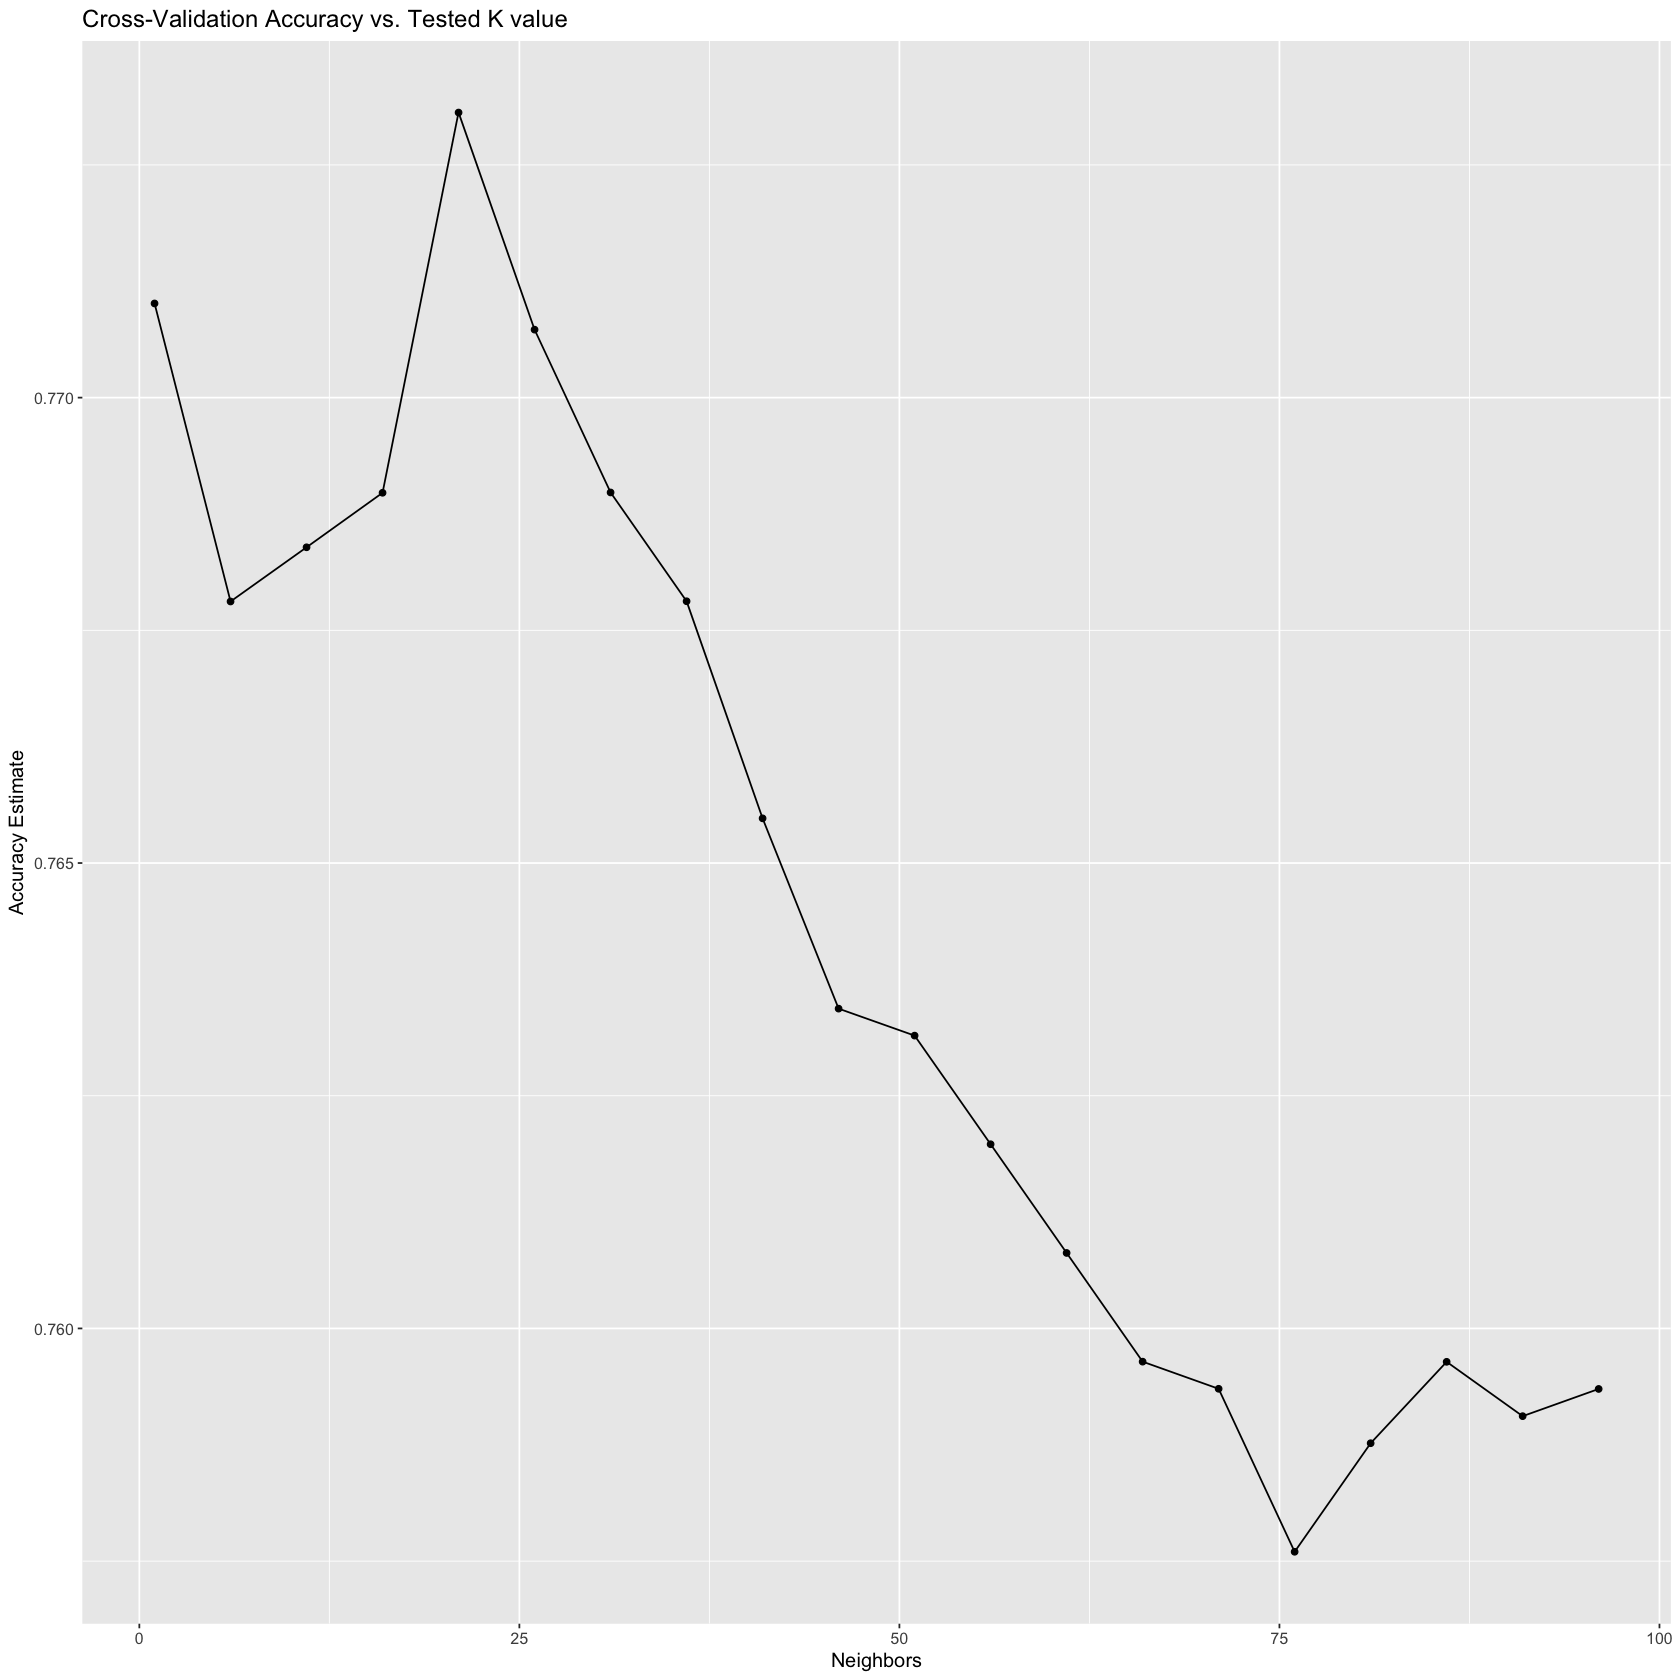

In [12]:
# generating the plot of accuracy for each tested k value
options(repr.plot.width=14, repr.plot.height=14)
accuracies_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                theme(text = element_text(size = 12)) +
                ggtitle("Cross-Validation Accuracy vs. Tested K value")

accuracies_vs_k

*Figure 2: Accuracy scores for different values of K*

We can see that as K becomes larger, the accuracy of the model decreases. The model is overfitted at low K values and tends toward underfitting as K increases. The ideal K value for this problem seems to be around 20-25.

In [13]:
# identifying best k value
best_k <- accuracies %>%
        arrange(desc(mean)) %>%
        head(1) %>%
        pull(neighbors)
cat("The best K value for this model is", as.character(best_k))

The best K value for this model is 21

In [14]:
# building classification model using best k value
wine_recipe <- recipe(quality_category ~ alcohol + chlorides + volatile_acidity + 
                      total_sulfur_dioxide + density ,
                      data = wine_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "optimal",
                             neighbors = best_k) %>%
            set_engine("kknn") %>%
            set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = wine_train)

In [15]:
# evaluating on test set
wine_test_predictions <- predict(knn_fit, wine_test) %>%
    bind_cols(wine_test)

wine_test_accuracy <- wine_test_predictions %>%
    metrics(truth = quality_category, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

wine_test_precision <- wine_test_predictions %>%
    precision(truth = quality_category, estimate = .pred_class, event_level="first")

wine_test_recall <- wine_test_predictions %>%
    recall(truth = quality_category, estimate = .pred_class, event_level="first")

wine_tests <- rbind(wine_test_accuracy, wine_test_precision, wine_test_recall)
wine_tests

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7734694
precision,binary,0.7918552
recall,binary,0.8946830


*Table 6: Accuracy and other metrics for evaluating the model*

In [16]:
confusion <- wine_test_predictions %>%
             conf_mat(truth = quality_category, estimate = .pred_class)
confusion

          Truth
Prediction good bad
      good  875 230
      bad   103 262

*Table 7: Confusion Matrix*

The table and matrix above present the accuracy, precision, and recall of our model on the test set. With an accuracy of 0.77, out model is good but can clearly be improved upon. Additionally, for the recall and precision tests, the good wine category is considered to be the positive class. We can see that the recall is high, meaning that the model has a high true positive rate (TPR).

## Discussion

The wine-quality prediction model seems to do okay with the test data, having an accuracy of 0.77. It does a decent job at classifying good wines as good, where ~90% of true good wines were predicted to be good-quality. However, the model seems to not have a high true negative rate; only ~50% of true bad wines were predicted to be bad quality. We could try to increase the sensitivity of the model or further optimize it, but seeing as wine quality tends to be quite subjective and that the implications of an incorrect prediction are not severe, this model is passable as a predictor. To improve this model, we could use a more concrete and quantitative approach to feature selection and choose a metric that is suited for a 1:2 class ratio within the dataset. We could also use a different classification strategy such as SVM or Random Forest Classifier. In its current state, this model is best used as a reference where wine producers and consumers can predict wine qualities while determining the quality through other means as well.

## References

Angerer P, Kluyver T, Schulz J (2023). _repr: Serializable Representations_. R package version 1.1.6, <https://CRAN.R-project.org/package=repr>.

Cortez,P., Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). _Wine Quality_. UCI Machine Learning Repository. <https://doi.org/10.24432/C56S3T>

CVRVV. (2024). Vinho Verde. <https://www.vinhoverde.pt/en/homepage>

Fernandes Ferreira Madureira,T.C. and Simões de Sousa Nunes, F.J. (2013), _Relevant attributes of Portuguese wines: matching regions and consumer's involvement level_, International Journal of Wine Business Research, Vol. 25 No. 1, pp. 75-86. <https://doi.org/10.1108/17511061311317318>

Kuhn et al., (2020). _Tidymodels: a collection of packages for modeling and machine learning using tidyverse principles._ <https://www.tidymodels.org>

R Core Team (2023). _R: A Language and Environment for Statistical Computing_. R Foundation for Statistical Computing, Vienna, Austria. <https://www.R-project.org/>

Schliep K, Hechenbichler K (2016). _kknn: Weighted k-Nearest Neighbors_. R package version 1.3.1, <https://CRAN.R-project.org/package=kknn>.

Wickham H, Averick M, Bryan J, Chang W, McGowan LD, François R, Grolemund G, Hayes A, Henry L, Hester J, Kuhn M, Pedersen TL, Miller E, Bache SM, Müller K, Ooms J, Robinson D, Seidel DP, Spinu V, Takahashi K, Vaughan D, Wilke C, Woo K, Yutani H (2019). “Welcome to the tidyverse.” _Journal of Open Source Software_, *4*(43), 1686. doi:10.21105/joss.01686 <https://doi.org/10.21105/joss.01686>

William Revelle (2024). _psych: Procedures for Psychological, Psychometric, and Personality Research_. Northwestern University, Evanston, Illinois. R package version 2.4.1 <https://CRAN.R-project.org/package=psych>.